# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.metrics import dtw
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, f1_score
from tslearn.utils import to_time_series_dataset

c:\Users\Admin\Documents\TimeSeries\tutorials-mva-2025-2026\venv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

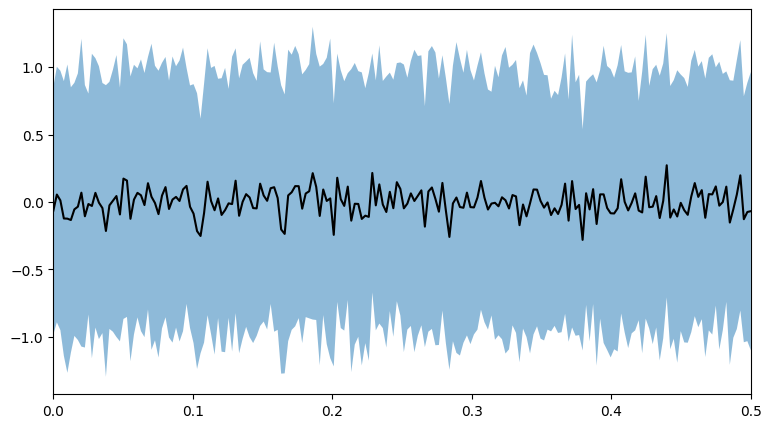

In [3]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
periodograms = np.random.randn(100, 200)  # shape (n_trials, n_freqs)
freqs = np.linspace(0, 0.5, 200)
##


fig, ax = fig_ax(figsize=(9, 5))

avg = periodograms.mean(axis=0)
std = periodograms.std(axis=0)
ax.plot(freqs, avg, 'k-')
ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)


In [4]:
def autocorr_function(x):
    N = len(x)
    gamma = np.zeros(2*N - 1)
    for tau in range(N):
        gamma[N-1+tau] = np.sum(x[:N-tau] * x[tau:]) / N
        gamma[N-1-tau] = gamma[N-1+tau]
    taus = np.arange(-(N-1), N)
    return taus, gamma

sig = 1
Ns = [200, 500, 1000]
num_sim = 100

for N in Ns:
    gammas = []
    for _ in range(num_sim):
        X = np.random.normal(0, sig, N)
        _, gamma = autocorr_function(X)
        gammas.append(gamma)
    gammas = np.array(gammas)
    mean_gamma = gammas.mean(axis=0)
    std_gamma = gammas.std(axis=0)
    taus = np.arange(-(N-1), N)
    
    plt.figure(figsize=(6, 4))
    plt.plot(taus, mean_gamma, label="Mean γ(τ)")
    plt.fill_between(taus, mean_gamma - std_gamma, mean_gamma + std_gamma, alpha=0.3, label="±1 std")
    plt.title(f"Autocorrelation (N={N})")
    plt.xlabel(r"$\tau$")
    plt.ylabel(r"$\gamma(\tau)$")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"autocorr_N{N}.png", dpi=300)
    plt.close()  


In [5]:
def compute_J(X, fs=1):
    N = len(X)
    J = (1/np.sqrt(N)) * np.fft.fft(X)
    f_k = fs * np.arange(N) / N
    return f_k[:N//2 + 1], np.abs(J[:N//2 + 1])**2

sig = 1
fs = 1
Ns = [200, 500, 1000]
num_sim = 100

for N in Ns:
    J2s = []
    for _ in range(num_sim):
        X = np.random.normal(0, sig, N)
        f_k, J2 = compute_J(X, fs)
        J2s.append(J2)
    J2s = np.array(J2s)
    mean_J2 = J2s.mean(axis=0)
    std_J2 = J2s.std(axis=0)
    
    plt.figure(figsize=(6, 4))
    plt.plot(f_k, mean_J2, label="Mean |J(f)|²")
    plt.fill_between(f_k, mean_J2 - std_J2, mean_J2 + std_J2, alpha=0.3, label="±1 std")
    plt.title(f"|J(f)|² (N={N})")
    plt.xlabel("Frequency f")
    plt.ylabel("|J(f)|²")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"J2_N{N}.png", dpi=300)
    plt.close()


## Question 9

In [6]:
def periodogram(X, fs=1):
    N = len(X)
    J = (1/np.sqrt(N)) * np.fft.fft(X)
    freqs = fs * np.arange(N) / N
    return freqs[:N//2 + 1], np.abs(J[:N//2 + 1])**2

def bartlett_psd(X, K=5, fs=1):
    N = len(X)
    L = N // K  # segment length
    P_segments = []
    for k in range(K):
        seg = X[k*L:(k+1)*L]
        J_seg = (1/np.sqrt(L)) * np.fft.fft(seg)
        P_seg = np.abs(J_seg[:L//2 + 1])**2
        P_segments.append(P_seg)
    P_segments = np.array(P_segments)
    P_bart = P_segments.mean(axis=0)
    freqs = fs * np.arange(L//2 + 1) / L
    return freqs, P_bart

# ---------- Parameters ----------
sig = 1
fs = 1
Ns = [200, 500, 1000]
num_sim = 100
K = 5

# ---------- Simulations ----------
results = {}

for N in Ns:
    freqs_p = None
    freqs_b = None
    P_periods = []
    P_barts = []
    
    for _ in range(num_sim):
        X = np.random.normal(0, sig, N)
        f_p, Pp = periodogram(X, fs)
        f_b, Pb = bartlett_psd(X, K=K, fs=fs)
        P_periods.append(Pp)
        P_barts.append(Pb)
        freqs_p = f_p
        freqs_b = f_b
    
    P_periods = np.array(P_periods)
    P_barts = np.array(P_barts)
    
    # Match frequencies between periodogram and Bartlett
    L = N // K
    matching_indices = np.arange(0, L//2 + 1) * K  # overlap points
    Pp_at_match = P_periods[:, matching_indices]
    
    # Compute means and stds
    mean_period = P_periods.mean(axis=0)
    std_period = P_periods.std(axis=0)
    mean_bart = P_barts.mean(axis=0)
    std_bart = P_barts.std(axis=0)
    
    # Variance ratio at matched frequencies (expected ≈ K)
    var_ratio = (Pp_at_match.var(axis=0)) / (P_barts.var(axis=0))
    mean_var_ratio = np.mean(var_ratio)
    
    avg_std_period = std_period.mean()
    avg_std_bart = std_bart.mean()
    std_ratio = avg_std_period / avg_std_bart  # expected ≈ sqrt(K)
    
    results[N] = {
        "freqs_period": freqs_p,
        "mean_period": mean_period,
        "std_period": std_period,
        "freqs_bart": freqs_b,
        "mean_bart": mean_bart,
        "std_bart": std_bart,
        "var_ratio_mean": mean_var_ratio,
        "avg_std_period": avg_std_period,
        "avg_std_bart": avg_std_bart,
        "std_ratio_mean": std_ratio
    }

# ---------- Save individual plots ----------
for N in Ns:
    res = results[N]
    plt.figure(figsize=(6, 4))
    plt.plot(res["freqs_bart"], res["mean_bart"], label="Mean Bartlett PSD")
    plt.fill_between(res["freqs_bart"],
                     res["mean_bart"] - res["std_bart"],
                     res["mean_bart"] + res["std_bart"],
                     alpha=0.3, label="±1 std")
    plt.title(f"Bartlett PSD (N={N}, K={K})")
    plt.xlabel("Frequency f")
    plt.ylabel("|J(f)|² (averaged)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"bartlett_psd_N{N}.png", dpi=300)
    plt.close()

# ---------- Print variance comparison ----------
print("Comparison statistics (Periodogram vs Bartlett K=5) over 100 simulations:")
for N in Ns:
    r = results[N]
    print(f"\nN = {N}:")
    print(f"  Mean variance ratio (periodogram var / bartlett var) ≈ {r['var_ratio_mean']:.3f} (expected ≈ {K})")
    print(f"  Average std: periodogram = {r['avg_std_period']:.4f}, bartlett = {r['avg_std_bart']:.4f}")
    print(f"  Std ratio (periodogram / bartlett) ≈ {r['std_ratio_mean']:.3f} (expected ≈ sqrt({K}) = {np.sqrt(K):.3f})")


Comparison statistics (Periodogram vs Bartlett K=5) over 100 simulations:

N = 200:
  Mean variance ratio (periodogram var / bartlett var) ≈ 4.819 (expected ≈ 5)
  Average std: periodogram = 0.9925, bartlett = 0.4667
  Std ratio (periodogram / bartlett) ≈ 2.127 (expected ≈ sqrt(5) = 2.236)

N = 500:
  Mean variance ratio (periodogram var / bartlett var) ≈ 5.495 (expected ≈ 5)
  Average std: periodogram = 0.9892, bartlett = 0.4453
  Std ratio (periodogram / bartlett) ≈ 2.221 (expected ≈ sqrt(5) = 2.236)

N = 1000:
  Mean variance ratio (periodogram var / bartlett var) ≈ 5.213 (expected ≈ 5)
  Average std: periodogram = 0.9858, bartlett = 0.4423
  Std ratio (periodogram / bartlett) ≈ 2.229 (expected ≈ sqrt(5) = 2.236)


# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [7]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [8]:
X_ts = to_time_series_dataset(X_train)

# Range of neighbors to test
neighbors_list = [1, 2, 3, 5, 7, 9, 11]

best_k = None
best_score = -1

# Define 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True)

for k in neighbors_list:
    model = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw")
    
    # Cross-validate using F1-score
    scores = cross_val_score(
        model, X_ts, y_train, cv=cv,
        scoring=make_scorer(f1_score)
    )
    
    mean_f1 = np.mean(scores)
    print(f"k={k}, mean F1={mean_f1:.3f}")
    
    if mean_f1 > best_score:
        best_score = mean_f1
        best_k = k

print("\nBest k:", best_k)
print("Best mean F1-score:", best_score)



k=1, mean F1=0.881
k=2, mean F1=0.862
k=3, mean F1=0.880
k=5, mean F1=0.872
k=7, mean F1=0.859
k=9, mean F1=0.825
k=11, mean F1=0.811

Best k: 1
Best mean F1-score: 0.8811394487865076


In [9]:
X_train_ts = to_time_series_dataset(X_train)
X_test_ts = to_time_series_dataset(X_test)

model = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
model.fit(X_train_ts, y_train)

y_pred = model.predict(X_test_ts)

print("Test F1-score:", f1_score(y_test, y_pred))
print("\nDetailed report:")
print(classification_report(y_test, y_pred))


Test F1-score: 0.48214285714285715

Detailed report:
              precision    recall  f1-score   support

           0       0.06      0.20      0.09        15
           1       0.69      0.37      0.48        73

    accuracy                           0.34        88
   macro avg       0.38      0.28      0.29        88
weighted avg       0.58      0.34      0.42        88



## Question 11

In [10]:
misclassified_indices = np.where(y_test != y_pred)[0]

false_positives = [i for i in misclassified_indices if y_test[i] == 0 and y_pred[i] == 1]
false_negatives = [i for i in misclassified_indices if y_test[i] == 1 and y_pred[i] == 0]

print("False positives (healthy predicted as non-healthy):", false_positives)
print("False negatives (non-healthy predicted as healthy):", false_negatives)


False positives (healthy predicted as non-healthy): [np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46)]
False negatives (non-healthy predicted as healthy): [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(24), np.int64(25), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71), np.int64(72), np.int64(78), np.int64(83), np.int64(87)]


In [12]:
def plot_bad_example(idx, true_label, pred_label, X_test):
    plt.figure(figsize=(8, 3))
    plt.plot(X_test[idx], color='red' if pred_label != true_label else 'green')
    plt.title(f"Misclassified sample #{idx}\nTrue: {true_label} | Predicted: {pred_label}")
    plt.xlabel("Time step")
    plt.ylabel("Feature value")
    plt.grid(True)
    
    # Save figure as PNG
    filename = f"bad_example_{idx}_true{true_label}_pred{pred_label}.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"Saved {filename}")

if false_positives:
    i = false_positives[0]
    plot_bad_example(i, y_test[i], y_pred[i], X_test)

if false_negatives:
    i = false_negatives[0]
    plot_bad_example(i, y_test[i], y_pred[i], X_test)


Saved bad_example_33_true0_pred1.png
Saved bad_example_0_true1_pred0.png
